# 2. Inference on real data

Author: [Marc Lelarge](https://www.di.ens.fr/~lelarge/)

Date: 04/05

In this notebook, we test our approach on real data taken from https://ourworldindata.org/coronavirus-source-data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np

## a. Loading the data

In [2]:
df = pd.read_csv('https://covid.ourworldindata.org/data/ecdc/full_data.csv', 
                     index_col='date', parse_dates=True)
df = df.rename(columns={'location': 'country', 'total_cases': 'confirmed', 'total_deaths': 'deaths'}) 

In [3]:
df.head()

,country,new_cases,new_deaths,confirmed,deaths
date,,,,,
2019-12-31,Afghanistan,0,0,0,0
2020-01-01,Afghanistan,0,0,0,0
2020-01-02,Afghanistan,0,0,0,0
2020-01-03,Afghanistan,0,0,0,0
2020-01-04,Afghanistan,0,0,0,0


In [4]:
pop_file = 'https://github.com/datasets/population/raw/master/data/population.csv'
populations_all = pd.read_csv(pop_file)
populations_all = populations_all.sort_values(['Country Name', 'Year']).groupby(['Country Name']).last()
populations_all.loc['Egypt'] = populations_all.loc['Egypt, Arab Rep.'].Value
populations_all.loc['Iran'] = populations_all.loc['Iran, Islamic Rep.'].Value
populations_all.loc['South Korea'] = populations_all.loc['Korea, Rep.'].Value
populations_all.loc['Hong Kong'] = populations_all.loc['Hong Kong SAR, China'].Value
populations_all.loc['Czechia'] = populations_all.loc['Czech Republic'].Value

## b. Case of France

In [5]:
df_france = df[df.country == 'France']

In [6]:
from model_epidemio import covid_data
from model_epidemio import ihd_fit

Our model is invariant by scaling (i.e. we can multiply all fractions and get the same equations). To avoid small numbers, we scale all fractions by a factor (here 100).

In [7]:
scale = 100
fr_pop = populations_all.loc['France']['Value']
death, new_cases = covid_data.create_death_cases(df_france,scale,fr_pop)

In [12]:
delta = 10
init = np.nonzero(new_cases)[0][0]+delta
t, data_death, data_cases = covid_data.make_data(death,new_cases,init,delta)

In [13]:
cases_init = data_cases[0].item()
parms_fit = torch.tensor([0.3,0.05,0.05,0.3])
ihd = ihd_fit.IHD_fit(parms_fit)
true_init = torch.tensor([[cases_init,0., 0.]])

In [14]:
optimizer = optim.RMSprop(ihd.parameters(), lr=1e-3)
criterion = nn.MSELoss()
best_loss, best_parms = ihd_fit.trainig(ihd, init=true_init, t=t, optimizer=optimizer,
                                        criterion=criterion,niters=200,data=(data_cases,data_death),all_data=False)

10 0.0028751979116350412 [tensor(0.2888), tensor(0.0612), tensor(0.0612), tensor(0.2876)]
20 0.001755142817273736 [tensor(0.2879), tensor(0.0621), tensor(0.0621), tensor(0.2858)]
30 0.001195600489154458 [tensor(0.2873), tensor(0.0627), tensor(0.0627), tensor(0.2844)]
40 0.0008665535715408623 [tensor(0.2868), tensor(0.0632), tensor(0.0632), tensor(0.2832)]
50 0.0006535114953294396 [tensor(0.2864), tensor(0.0636), tensor(0.0636), tensor(0.2823)]
60 0.0005065423320047557 [tensor(0.2860), tensor(0.0640), tensor(0.0640), tensor(0.2814)]
70 0.00040049583185464144 [tensor(0.2857), tensor(0.0643), tensor(0.0643), tensor(0.2807)]
80 0.00032138975802809 [tensor(0.2855), tensor(0.0646), tensor(0.0645), tensor(0.2800)]
90 0.0002608609211165458 [tensor(0.2852), tensor(0.0648), tensor(0.0648), tensor(0.2794)]
100 0.00021361459221225232 [tensor(0.2850), tensor(0.0650), tensor(0.0650), tensor(0.2788)]
110 0.00017614371608942747 [tensor(0.2848), tensor(0.0652), tensor(0.0652), tensor(0.2783)]
120 0.000

In [15]:
ihd_inf = ihd_fit.get_best_model_simple(best_parms)
y_inf = ihd_fit.predic_ode(ihd_inf, true_init,t)

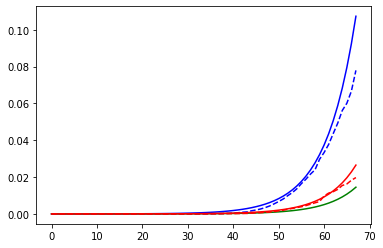

In [16]:
plt.plot(y_inf[:,0], 'b')
plt.plot(data_cases, 'b--')
plt.plot(y_inf[:,1], 'g')
plt.plot(y_inf[:,2], 'r')
plt.plot(data_death, 'r--')

Infected = Blue, Hospital = green, Deaths = red; dashed = true, plain = estimated

We see that there is a problem with the model: the number os estimated individuals at the hospital is too low. This is confirmed by the data below.

In [17]:
date=
data_hospital = pd.read_csv(
    f"https://static.data.gouv.fr/resources/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/{20200411}-190014/donnees-hospitalieres-covid19-{2020-04-11}-19h00.csv", sep=";")

In [18]:
df_hospital = data_hospital.loc[data_hospital['sexe']!=0].groupby(['jour']).agg({'hosp' : 'sum', 'rea' : 'sum', 'rad' : 'sum', 'dc':'sum'}).reset_index() 

In [19]:
hosiptal_fr =list(df_hospital['hosp'])/fr_pop*scale

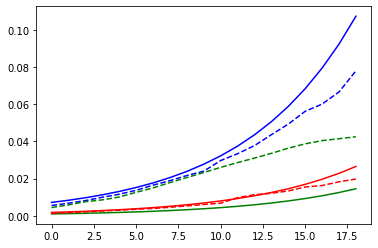

In [20]:
plt.plot(y_inf[-19:,0], 'b')
plt.plot(data_cases[-19:], 'b--')
plt.plot(y_inf[-19:,1], 'g')
plt.plot(hosiptal_fr, 'g--')
plt.plot(y_inf[-19:,2], 'r')
plt.plot(data_death[-19:], 'r--')

Infected = Blue, Hospital = green, Deaths = red; dashed = true, plain = estimated

We see that the number of infected is largely underestimated as it is below the number of individuals in hospital. The number of tests is probably not sufficient to get an accurate estimate of the infected individuals.

With our model, we can try to infer this number of infected individual from the number of individuals in hospital. TBD.

## c. case of South Korea

In [168]:
df_sk = df[df.country == 'South Korea']
sk_pop = populations_all.loc['South Korea']['Value']

In [187]:
death, new_cases = covid_data.create_death_cases(df_sk,scale,sk_pop)
delta = 10
init = np.nonzero(new_cases)[0][0]+delta
t, data_death, data_cases = covid_data.make_data(death,new_cases,init,delta)

In [202]:
parms_fit = torch.tensor([0.2,-0.05,0.05,0.05,0.2])
time_fit = torch.tensor([40.])
ihd_time = ihd_fit.IHD_fit_time(parms_fit,time_fit)
true_init = torch.tensor([[cases_init,0., 0.]])

In [203]:
optimizer_time = optim.RMSprop([{'params': [ihd_time.b1, ihd_time.b2, ihd_time.g, ihd_time.nu, ihd_time.l]},
                                {'params': ihd_time.time, 'lr' : 1.}], lr=1e-3)
criterion = nn.MSELoss()

In [204]:
best_loss, best_parms = ihd_fit.trainig(ihd_time, init=true_init, t=t, optimizer=optimizer_time,
                                        criterion=criterion,niters=500,data=(data_cases,data_death),all_data=False)

10 3.443796231294982e-05 [tensor(0.2112), tensor(-0.0382), tensor(0.0388), tensor(0.0387), tensor(0.1783), tensor([48.4041])]
20 2.4009832486626692e-05 [tensor(0.2128), tensor(-0.0366), tensor(0.0372), tensor(0.0371), tensor(0.1696), tensor([50.2911])]
30 2.2401020032702945e-05 [tensor(0.2134), tensor(-0.0374), tensor(0.0366), tensor(0.0364), tensor(0.1568), tensor([50.7088])]
40 2.1887839466216974e-05 [tensor(0.2136), tensor(-0.0391), tensor(0.0365), tensor(0.0362), tensor(0.1428), tensor([50.6154])]
50 2.136257717211265e-05 [tensor(0.2137), tensor(-0.0410), tensor(0.0363), tensor(0.0359), tensor(0.1287), tensor([50.4581])]
60 2.080521335301455e-05 [tensor(0.2139), tensor(-0.0429), tensor(0.0362), tensor(0.0357), tensor(0.1146), tensor([50.2971])]
70 2.0215056792949326e-05 [tensor(0.2141), tensor(-0.0450), tensor(0.0360), tensor(0.0354), tensor(0.1006), tensor([50.1381])]
80 1.9592485841712914e-05 [tensor(0.2142), tensor(-0.0473), tensor(0.0358), tensor(0.0352), tensor(0.0868), tensor

In [207]:
optimizer_time = optim.RMSprop([{'params': [ihd_time.b1, ihd_time.b2, ihd_time.g, ihd_time.nu, ihd_time.l]},
                                {'params': ihd_time.time, 'lr' : .1}], lr=1e-4)
criterion = nn.MSELoss()

In [208]:
best_loss, best_parms = ihd_fit.trainig(ihd_time, init=true_init, t=t, optimizer=optimizer_time,
                                        criterion=criterion,niters=200,data=(data_cases,data_death),all_data=False)

10 2.3596980724960304e-07 [tensor(0.2245), tensor(-0.1576), tensor(0.0256), tensor(0.0246), tensor(0.0051), tensor([45.9100])]
20 2.2119274944998324e-07 [tensor(0.2246), tensor(-0.1581), tensor(0.0255), tensor(0.0245), tensor(0.0050), tensor([45.8660])]
30 2.0876670703273703e-07 [tensor(0.2247), tensor(-0.1586), tensor(0.0254), tensor(0.0245), tensor(0.0050), tensor([45.8271])]
40 1.983936499527772e-07 [tensor(0.2247), tensor(-0.1590), tensor(0.0254), tensor(0.0244), tensor(0.0050), tensor([45.7924])]
50 1.8981343430368725e-07 [tensor(0.2248), tensor(-0.1594), tensor(0.0253), tensor(0.0244), tensor(0.0050), tensor([45.7617])]
60 1.8278429081419745e-07 [tensor(0.2249), tensor(-0.1598), tensor(0.0253), tensor(0.0243), tensor(0.0050), tensor([45.7347])]
70 1.7708440225305822e-07 [tensor(0.2249), tensor(-0.1602), tensor(0.0252), tensor(0.0243), tensor(0.0050), tensor([45.7112])]
80 1.7251257133921172e-07 [tensor(0.2249), tensor(-0.1605), tensor(0.0252), tensor(0.0242), tensor(0.0050), tens

In [209]:
ihd_inf = ihd_fit.get_best_model(best_parms)
y_inf = ihd_fit.predic_ode(ihd_inf, true_init,t)

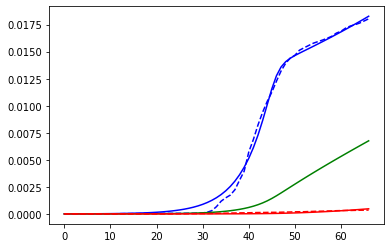

In [210]:
plt.plot(y_inf[:,0], 'b')
plt.plot(data_cases, 'b--')
plt.plot(y_inf[:,1], 'g')
plt.plot(y_inf[:,2], 'r')
plt.plot(data_death, 'r--')

Infected = Blue, Hospital = green, Deaths = red; dashed = true, plain = estimated